# News Recommender: Natural Language Processing

*insert title page* with links

## CLEANING AND VECTORIZATION
In the first section of this notebook, we will be pre-processing, cleaning, lemmatizing, tagging, and vectorizing our webscraped tweets. The goal is to create an optimized document-term matrix for topic modeling.

In [145]:
import pandas as pd
import numpy as np
import spacy
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0
import unicodedata
from wordcloud import WordCloud
import matplotlib.pyplot as plt 
import nltk.corpus
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity

### Prepare Dataframe

Read in CSV as dataframe, edit columns, drop unnecessary columns.

In [475]:
df_raw = pd.read_csv('df_raw.csv', encoding='utf-8')

In [476]:
#drop old index as we've reindex when reading in our CSV
df_raw = df_raw.drop(columns = 'Unnamed: 0')

In [477]:
df_raw.head()

,user,date,outlinks,content,url
0,"{'username': 'TheAtlantic', 'displayname': 'Th...",2020-11-01T01:08:48+00:00,['http://on.theatln.tc/YXH6gyR'],The Atlantic Daily: Will this decade be the ne...,https://twitter.com/TheAtlantic/status/1322707...
1,"{'username': 'TheAtlantic', 'displayname': 'Th...",2020-11-01T00:38:45+00:00,['http://on.theatln.tc/l89Uzv7'],There's plenty that's going wrong for Trump. H...,https://twitter.com/TheAtlantic/status/1322699...
2,"{'username': 'TheAtlantic', 'displayname': 'Th...",2020-11-01T00:06:48+00:00,['http://on.theatln.tc/ZGvkM7u'],"If Trump tries to steal the election, people w...",https://twitter.com/TheAtlantic/status/1322691...
3,"{'username': 'TheAtlantic', 'displayname': 'Th...",2020-10-31T23:34:45+00:00,['http://on.theatln.tc/kypt5Zc'],The Trump campaign's “election-security operat...,https://twitter.com/TheAtlantic/status/1322683...
4,"{'username': 'TheAtlantic', 'displayname': 'Th...",2020-10-31T23:04:31+00:00,['http://on.theatln.tc/rNbarVc'],"Even if Joe Biden wins decisively next week, t...",https://twitter.com/TheAtlantic/status/1322675...


Let's also add in a column to easily distinguish our different news outlets.

In [478]:
#create new column of outlet names based off tweet urls
df_raw['outlet'] = df_raw['url'].apply(lambda url: (url.split(".com/", 2)[-1]).split('/')[0])


Check to see if all of our outlets are represented with 20k tweets/rows each:

In [479]:
df_raw.outlet.value_counts()

nytimes            20000
washingtonpost     20000
Medium             20000
TheEconomist       20000
TheAtlantic        20000
WSJ                20000
FinancialTimes     20000
NewYorker          20000
WIRED              20000
businessinsider    20000
Name: outlet, dtype: int64

Let's now drop the columns we don't need and reindex the remaining ones for easier querying.

In [480]:
df_raw.columns

Index(['user', 'date', 'outlinks', 'content', 'url', 'outlet'], dtype='object')

In [481]:
#drop our original "user" column now that we have "outlet"
df_raw.drop(columns = ['user'], inplace = True)

In [482]:
#reindex the columns for easier viewing
cols = df_raw.columns.tolist()

cols.insert(0, cols.pop(cols.index('outlet')))
cols.insert(2, cols.pop(cols.index('url')))

df_raw= df_raw.reindex(columns= cols)

In [483]:
df_raw.head()

,outlet,date,url,outlinks,content
0,TheAtlantic,2020-11-01T01:08:48+00:00,https://twitter.com/TheAtlantic/status/1322707...,['http://on.theatln.tc/YXH6gyR'],The Atlantic Daily: Will this decade be the ne...
1,TheAtlantic,2020-11-01T00:38:45+00:00,https://twitter.com/TheAtlantic/status/1322699...,['http://on.theatln.tc/l89Uzv7'],There's plenty that's going wrong for Trump. H...
2,TheAtlantic,2020-11-01T00:06:48+00:00,https://twitter.com/TheAtlantic/status/1322691...,['http://on.theatln.tc/ZGvkM7u'],"If Trump tries to steal the election, people w..."
3,TheAtlantic,2020-10-31T23:34:45+00:00,https://twitter.com/TheAtlantic/status/1322683...,['http://on.theatln.tc/kypt5Zc'],The Trump campaign's “election-security operat...
4,TheAtlantic,2020-10-31T23:04:31+00:00,https://twitter.com/TheAtlantic/status/1322675...,['http://on.theatln.tc/rNbarVc'],"Even if Joe Biden wins decisively next week, t..."


### Preprocessing

Clean our text for special characters using regex and encode to ascii to get rid of any emojis.

In [484]:
def preprocess(tweet):
    """
    Takes in tweet and performs initial text cleaning/preprocessing.
    """
    #make sure doc is string
    tweet=str(tweet)
    #get rid of urls
    rem_url=re.sub(r'http\S+', '', tweet)
    #gets rid of @ tags
    rem_tag = re.sub('@\S+', '', rem_url)
    #gets rid of # in hashtag but keeps content of hashtag
    rem_hashtag = re.sub('#', '', rem_tag)
    #gets rid of apostrophes 
    rem_apos = re.sub("'.\S", '', rem_hashtag)
    rem_apos_0 = re.sub("’.\S", '', rem_apos)
    rem_apos_1 = re.sub("'\S", '', rem_apos_0)
    rem_apos_2 = re.sub("’\S", '', rem_apos_1)
    #gets rid of special characters, numbers, etc.
    clean_text = re.sub(r'[^A-Za-z\s]','', rem_apos_2)

    return clean_text

In [485]:
df_raw['clean']=df_raw['content'].map(preprocess)

Decode our webscrapped tweets into ascii so we can remove emojis and foreign characters easily during our pre-processing steps.

In [486]:
#decoded unicode into ascii
df_raw['clean'] = df_raw['clean'].apply(lambda x: unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('ascii'))

Run our clean code through our preprocessing function again in case we missed anything the first time around when the code wasn't in ascii.

In [487]:
df_raw['clean']=df_raw['clean'].map(preprocess)

### Standardize Language

Let's remove any foreign language tweets to make sure we're only focusing on English. 

In [489]:
def english_only(x):
    """
    Take tweet, detect language, and only return English tweets, coding foreign language tweets as NaNs.
    """
    try:
        if detect(x) == 'en':
            return x
        else:
            return np.nan
    except:
        pass


In [490]:
%%time
#  Remove any non english tweets
df_raw['clean_eng'] = df_raw['clean'].apply(lambda x: english_only(x))


CPU times: user 10min 48s, sys: 3.87 s, total: 10min 52s
Wall time: 10min 55s


In [491]:
df_raw.clean_eng.isnull().sum()


1287

In [492]:
#fill our null value non-English tweets with empty string
df_raw = df_raw.fillna(" ")

### Remove Duplicate Tweets
Let's make sure we remove any duplicate tweets from the same news source

In [496]:
#explore duplicate tweets from the same account
df_raw['Is_Duplicate']= df_raw.duplicated(subset = ['outlet', 'clean_eng'])
df_raw[df_raw['Is_Duplicate']== True].sort_values(by=['clean_eng']).head()


,outlet,date,url,outlinks,content,clean,clean_eng,Is_Duplicate
16,TheAtlantic,2020-10-31T14:42:13+00:00,https://twitter.com/TheAtlantic/status/1322549...,['http://on.theatln.tc/6QI8XY4'],"If Trump tries to steal the election, people w...",If Trump tries to steal the election people wi...,NaN,True
17,TheAtlantic,2020-10-31T14:19:17+00:00,https://twitter.com/TheAtlantic/status/1322543...,['http://on.theatln.tc/VURlE4o'],"Endings are seductive. They suggest order, and...",Endings are seductive They suggest order and r...,NaN,True
18,TheAtlantic,2020-10-31T13:58:37+00:00,https://twitter.com/TheAtlantic/status/1322538...,['http://on.theatln.tc/dNldIY4'],The Trump campaign's “election-security operat...,The Trump campaign electionsecurity operation ...,NaN,True
20,TheAtlantic,2020-10-31T13:02:02+00:00,https://twitter.com/TheAtlantic/status/1322524...,['http://on.theatln.tc/sUR08l8'],The Atlantic Daily: Will this decade be the ne...,The Atlantic Daily Will this decade be the new s,NaN,True
21,TheAtlantic,2020-10-30T19:04:48+00:00,https://twitter.com/TheAtlantic/status/1322253...,['http://on.theatln.tc/8KBTKT7'],"""When Trump is gone (whether after this electi...",When Trump is gone whether after this election...,NaN,True


In [497]:
#get index values of duplicate rows
dupe_index = df_raw[df_raw['Is_Duplicate']==True].index
#change "clean_eng" column of these rows to NaN
df_raw['clean_eng'].iloc[dupe_index] = np.nan
#fill the NaNs with empty string
df_raw = df_raw.fillna(" ")
#drop the duplicate row
df_raw.drop(columns = 'Is_Duplicate', inplace = True)

/Users/juliaqiao/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Remove Repetitive Article Introductions:
As we saw later in our topic modeling, a number of Financial Times tweets are part of series and thus have the same type of introduction containing keywords that do not speak to the article itself, but to its audience:

"Good Morning, Hong Kong. While you were sleeping, this was our most read story"

"Hello, Hong Kong. While you were sleeping, this was our most read story"

"Just published: front page of the Financial Times, UK edition"

In [498]:
#let's find the indexes of any tweets we might've missed where Fin Times introduces articles with the same description that speaks to audience not content

fin_times = df_raw[df_raw['outlet'].str.contains('FinancialTimes') & (df_raw['clean'].str.contains('Hello') | df_raw['clean'].str.contains('Good morning') | df_raw['clean'].str.contains('Just published'))]
fin_times_index = fin_times.index
fin_times


,outlet,date,url,outlinks,content,clean,clean_eng
60033,FinancialTimes,2020-10-30T20:45:06+00:00,https://twitter.com/FinancialTimes/status/1322...,['https://on.ft.com/3jFO57j'],Just published: front page of the Financial Ti...,Just published front page of the Financial Tim...,Just published front page of the Financial Tim...
60034,FinancialTimes,2020-10-30T20:45:05+00:00,https://twitter.com/FinancialTimes/status/1322...,['https://on.ft.com/35O6euX'],Just published: front page of the Financial Ti...,Just published front page of the Financial Tim...,Just published front page of the Financial Tim...
60110,FinancialTimes,2020-10-30T00:01:04+00:00,https://twitter.com/FinancialTimes/status/1321...,['https://on.ft.com/3kJOLtU'],"Hello, Hong Kong. While you were sleeping, thi...",Hello Hong Kong While you were sleeping this w...,Hello Hong Kong While you were sleeping this w...
60114,FinancialTimes,2020-10-29T21:44:07+00:00,https://twitter.com/FinancialTimes/status/1321...,['https://on.ft.com/3efjL2j'],Just published: front page of the Financial Ti...,Just published front page of the Financial Tim...,Just published front page of the Financial Tim...
60121,FinancialTimes,2020-10-29T20:54:04+00:00,https://twitter.com/FinancialTimes/status/1321...,['https://on.ft.com/37P8iFz'],Just published: front page of the Financial Ti...,Just published front page of the Financial Tim...,Just published front page of the Financial Tim...
...,...,...,...,...,...,...,...
79883,FinancialTimes,2019-10-11T12:20:02+00:00,https://twitter.com/FinancialTimes/status/1182...,['https://on.ft.com/328GjLc'],Good morning New York. While you were sleeping...,Good morning New York While you were sleeping ...,
79922,FinancialTimes,2019-10-10T21:30:15+00:00,https://twitter.com/FinancialTimes/status/1182...,['https://on.ft.com/33jJ9NF'],Just published: front page of the Financial Ti...,Just published front page of the Financial Tim...,
79953,FinancialTimes,2019-10-10T12:20:08+00:00,https://twitter.com/FinancialTimes/status/1182...,['https://ft.trib.al/vqvB9Ve'],Good morning New York. While you were sleeping...,Good morning New York While you were sleeping ...,
79986,FinancialTimes,2019-10-09T21:30:16+00:00,https://twitter.com/FinancialTimes/status/1182...,['https://on.ft.com/35mxbVx'],Just published: front page of the Financial Ti...,Just published front page of the Financial Tim...,


In [499]:
#change "clean" column of these rows to NaN
df_raw['clean_eng'].iloc[fin_times_index] = np.nan

Before we move onto further processing, let's fill our rows with nans and create a copy of the dataframe for manipulation later:

In [500]:
#fill the NaNs with empty string
df_raw = df_raw.fillna(" ")

In [501]:
df = df_raw.copy()

In [502]:
df.shape

(200000, 7)

### Tagging and Lemmatizing

We only want the nouns (and proper nouns) in each tweet for topic modeling, as they are the essence of article subjects. Let's tag the nouns and return the lemmatized versions of tehm in a single step.

Because we also have so much data, we will incoporate the NLP pipeline in order to shorten the processing time. Tips on how to do this were found here: https://towardsdatascience.com/turbo-charge-your-spacy-nlp-pipeline-551435b664ad

In [503]:
nlp = spacy.load('en_core_web_sm', disable=[ 'parser', 'ner'])

In [504]:
def noun_lemmatize_pipe(doc):
    """
    Takes in tweet and returns only the lemmatized version of nouns (including proper nouns).
    """
    lemma_list = [token.lemma_.lower() for token in doc
                  if token.pos_ == "NOUN" or token.pos_ =="PROPN"] 
    return lemma_list

#create a pipeline in order to shorten processing time
def preprocess_pipe(texts):
    """
    Inputs noun_lemmative_pipe function into NLP pipeline for faster processing.
    """
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=50):
        preproc_pipe.append(noun_lemmatize_pipe(doc))
    return preproc_pipe

In [505]:
%%time
#apply function and create a new column to house the outputs
df['clean_lemmatized'] = preprocess_pipe(df['clean_eng'])


CPU times: user 1min 52s, sys: 1.27 s, total: 1min 53s
Wall time: 2min


In [506]:
df[['content', 'clean_eng', 'clean_lemmatized']].head(3)

,content,clean_eng,clean_lemmatized
0,The Atlantic Daily: Will this decade be the ne...,The Atlantic Daily Will this decade be the new s,"[atlantic, daily, decade, s]"
1,There's plenty that's going wrong for Trump. H...,There plenty that going wrong for Trump Here a...,"[trump, thing, campaign, gap, joe, biden, report]"
2,"If Trump tries to steal the election, people w...",If Trump tries to steal the election people wi...,"[trump, election, people, coup, strategy, write]"


We've successfully filtered out the nouns and proper nouns, lemmitized them, while making sure our function runs on optimized time!

### Remove Additional Words

Let's filter out any additional words that may appear in the tweets but aren't related to article subjects, like the names of the publications and common headline section titles.

Our removal words also include ones that have surfaced in our continuously iterative topic modeling process--any words that pop up as sigfnicant 'topic words' but do not have signficant meaning/are blanket terms will hinder our models and are thus added to this list.

In [889]:
removal_words= ["times", "wall", "street", "journal", "new", "yorker", "york", "medium", "wired", "financial", "washington", "post", "business", "insider", "economist", "the", "atlantic", "daily", "weekly", "monthly", "week", "day", "month", "quarter", "year", "sponsored", "Breaking", "news", 'way', 'page', 'edition', 'morning', 'monday', 'tuesday', 'wednesday', 'thursday','friday','saturday','sunday', 'thing', 'briefing', 'day', 'story', 'year', 'life', 'write', 'wrote', 'time', 'closer', 'look', 'opinion', 'opinions', 'looks', 'wsjwhatsnow', 'analysis', 'world', 'today', 'house', "today's", 'tomorrow', 'yesterday', 'question', 'questions', 'report', 'reports', 'number', 'thing', 'one', 'opinion', 'perspective']

In [890]:
df['clean_removed'] = df['clean_lemmatized'].apply(lambda x: [word for word in x if word not in removal_words])

One last check to make sure we don't have any outstanding null values:

In [891]:
df.isnull().values.any()

False

### Vectorize
Now let's rejoin our twice cleaned, lemmatized list of nouns and pronouns!

In [892]:
df['clean_final'] = df['clean_removed'].apply(lambda x: ' '.join(x))

In [893]:
df[['content', 'clean_eng', 'clean_lemmatized', 'clean_removed', 'clean_final']].head(3)

,content,clean_eng,clean_lemmatized,clean_removed,clean_final
0,The Atlantic Daily: Will this decade be the ne...,The Atlantic Daily Will this decade be the new s,"[atlantic, daily, decade, s]","[decade, s]",decade s
1,There's plenty that's going wrong for Trump. H...,There plenty that going wrong for Trump Here a...,"[trump, thing, campaign, gap, joe, biden, report]","[trump, campaign, gap, joe, biden]",trump campaign gap joe biden
2,"If Trump tries to steal the election, people w...",If Trump tries to steal the election people wi...,"[trump, election, people, coup, strategy, write]","[trump, election, people, coup, strategy]",trump election people coup strategy


We will be using TFID Vectorizer as opposed to Count Vectorizer, so we can give equal weight to rare words. Because our focus is on nouns and pronouns, rare words are likely to be just as, if not more impactful, as words that are frequently used. 

We'll also be using some of the built in parameters in the TFID Vectorizer as last checks before we output our doc-term matrix. 

We'll be adding a few stopwords specific to our dataset:

In [1047]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['worker', 'coronavirus', 'virus', 'covid', 'president', 'death',
                'american', 'americans', "america's", 'america', "american's", 'government', 
            'governments', 'city', 'country', 'state', 'us', 'official', 'crisis', 'mask', 'people']
stopwords.extend(newStopWords)

In [1048]:
#define vectorizer and set parameters in order to standardize everything to lowercase, remove any stop words, and remove any word that appears below 0.005%, about 10 times, and max of more than 30%.
tfidf = TfidfVectorizer(lowercase = True, stop_words= stopwords, min_df = 0.00005, max_df = 0.30)
#fit on fully cleaned dataframe column
doc_term_matrix = tfidf.fit_transform(df['clean_final'])
#turn matrix into a dataframe with words as columns
matrix_df = pd.DataFrame(doc_term_matrix.toarray(), columns=tfidf.get_feature_names())

In [1049]:
matrix_df

,aaron,ab,abbey,abbott,abby,abc,abe,abigail,ability,abiy,...,zhiqiang,zimbabwe,zip,zombie,zone,zoo,zoological,zoom,zora,zuckerberg
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Our doc-term matrix looks great! We have fully cleaned out all special characters and foreign language. We have extracted the nouns and pronouns in their lemmatized forms. Now we can topic model!


## VISUALIZATON

Before we topic model, let's visualize our word frequency from our final doc term matrix using a word cloud!

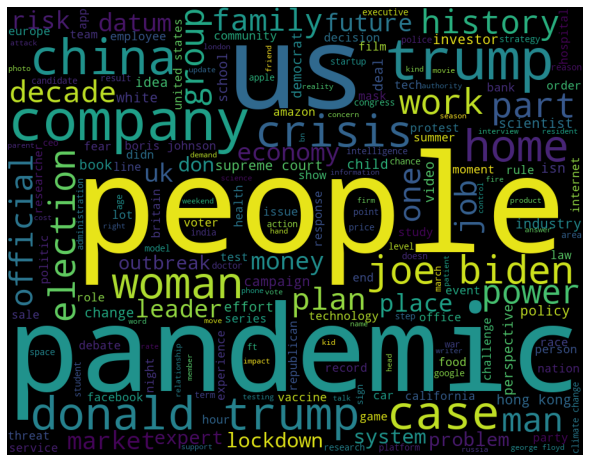

In [710]:
clean_words = ' '.join([doc for doc in df['clean_final']])

wordcloud = WordCloud(width = 900, height = 700, 
                background_color ='black', 
                min_font_size = 10).generate(clean_words) 
  
# plot word cloud                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('wordcloud.png', dpi=300)

Our most commonly occuring word is "people." Let's see how many times it appears (which should be under 30% of the entire corpus due to the maximum_df we set during vectorization).

In [393]:
#how many times does our top word appear?
counter = 0
for word in df['clean_final']:
    if "people" in word:
        counter = counter +1
print(counter)

8234


That looks good. We can now move on to...

## TOPIC MODELING
In the second section of this notebook, we will be topic modeling.

### LSA

In [970]:
lsa = TruncatedSVD(30)
doc_topic = lsa.fit_transform(doc_term_matrix)

In [686]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for idx, topic in enumerate(model.components_):
        if not topic_names or not topic_names[idx]:
            print("\nTopic ", idx)
        else:
            print("\nTopic: '",topic_names[idx],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [971]:
display_topics(lsa, tfidf.get_feature_names(), 10)


Topic  0
trump, people, pandemic, donald, biden, joe, election, case, china, company

Topic  1
people, pandemic, home, company, case, health, china, work, job, economy

Topic  2
pandemic, company, economy, china, market, stock, job, health, case, school

Topic  3
case, company, china, market, stock, election, tech, hong, kong, economy

Topic  4
biden, joe, election, campaign, debate, company, voter, woman, harris, party

Topic  5
case, biden, joe, pandemic, court, debate, infection, campaign, supreme, florida

Topic  6
china, hong, kong, economy, beijing, law, outbreak, trade, war, security

Topic  7
election, court, supreme, ballot, voter, uk, voting, johnson, november, party

Topic  8
woman, home, police, man, school, health, child, family, protest, work

Topic  9
market, stock, economy, home, investor, job, health, uk, lockdown, price

Topic  10
home, health, school, election, child, china, care, student, company, vaccine

Topic  11
home, market, case, stock, woman, china, election

We see a lot of words repeated across categories, so let's try another model--NMF

### NMF

NMF works very well for our dataset and it is the model we will be sticking to for topic modeling!

After a few iterations, going back and forth in the process of cleaning and using NMF to model topics, I've selected 26 topics as my optimal number. 

After testing NMF for 10, 20, 25, then 30 topics, 26 topics met our expectation of nuance while also being as concise enough. It is a large number, but the topics easily fit into themes, so it is not a concern.

In [1058]:
nmf = NMF(26, max_iter = 500)
doc_topic = nmf.fit_transform(doc_term_matrix)

In [1059]:
display_topics(nmf, tfidf.get_feature_names(), 10)


Topic  0
trump, donald, administration, white, campaign, impeachment, republicans, poll, reelection, rally

Topic  1
pandemic, response, sale, industry, toll, travel, food, restaurant, demand, million

Topic  2
company, employee, tech, ceo, executive, technology, office, product, startup, share

Topic  3
biden, joe, debate, campaign, voter, harris, poll, kamala, bernie, sanders

Topic  4
case, infection, outbreak, surge, florida, toll, record, rate, update, lockdown

Topic  5
china, outbreak, trade, war, beijing, india, tension, wuhan, administration, taiwan

Topic  6
election, voter, ballot, november, voting, result, campaign, mail, vote, poll

Topic  7
home, nursing, office, resident, sale, tip, lockdown, place, employee, california

Topic  8
market, stock, investor, price, tech, oil, share, future, bank, rally

Topic  9
police, protest, officer, george, floyd, man, protester, violence, department, video

Topic  10
health, expert, care, system, risk, hospital, patient, doctor, organ

NMF works better than LSA. It has been a feedback loop of topic modeling and cleaning, but I feel good about these results. They look very clean. Let's try to have more topics, because that will make the topics themselves more precise, and let's take a look at the specific tweets as well.

### NMF Topic Interpretation

Now that I've decided on NMF, I will be going through an interative process of interpreting and optimizing our topics. 

I'll be interpreting the top words and top tweets of each topic, going down the list of 30, then jotting down any words I need to add to our removal list, adding those words, vectorizing again, and then going through this topic interpretation workflow again, until I am happy with the topics. I will not be displaying the results of each optimization iteration--only the final results:

In [1060]:
tweet_topic_matrix = nmf.fit_transform(doc_term_matrix)
tweet_topic_matrix_df = pd.DataFrame(tweet_topic_matrix).add_prefix('topic_')


In [1148]:
#pickle out tweet topic matrix dataframe
tweet_topic_matrix_df.to_pickle('tweet_topic_matrix_df.pickle')

In [1061]:
tweet_topic_matrix.shape

(200000, 26)

In [1146]:
tweet_topic_matrix_df[['outlet','content', 'clean_final']] = df[['outlet', 'content', 'clean_final']]

In [1147]:
tweet_topic_matrix_df.shape

(200000, 29)

In [1064]:
word_topic_matrix_df = pd.DataFrame(nmf.components_, columns=tfidf.get_feature_names()).T.add_prefix('topic_')


In [1128]:
#pickle our word topic dataframe
word_topic_matrix_df.to_pickle('word_topic_matrix_df.pickle')

In [1065]:
word_topic_matrix_df.shape

(8851, 26)

In [981]:
def top_tweets(tweet_topic_matrix_df, topic, n_tweets):
    """
    """
    return (tweet_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_tweets)['content']
            .values)

def top_words(word_topic_matrix_df, topic, n_words):
    """
    """
    return (word_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_words))[topic]




#### Topic 1: Trump

In [1066]:
top_words(word_topic_matrix_df, 'topic_0', 10)

trump             6.504658
donald            2.035211
administration    0.464550
white             0.414955
campaign          0.236943
impeachment       0.213118
republicans       0.195825
reelection        0.154541
poll              0.152163
democrats         0.149445
Name: topic_0, dtype: float64

In [1149]:
top_tweets(tweet_topic_matrix_df ,'topic_0', 10)

array(['Here’s what we know so far about where President Trump traveled and the people he met in the days before he tested positive. https://t.co/pXKYNIA2FX',
       'Analysis: Why Trump is losing https://t.co/MMSYZwRbvS',
       'Opinion: Even whites — except the right-wing media profiteers — are abandoning Trump https://t.co/PoPN6sl7G2',
       'Opinion: It is easy to explain why Trump is losing https://t.co/dK4x9dc6LH',
       'Analysis: Trump claims nothing more could have been done to defeat the coronavirus. He’s wrong. https://t.co/pw7n38oCWw',
       'As bigots blame them for the coronavirus and President Trump labels it the "Chinese virus," many Chinese-Americans say they are terrified of what could come next. https://t.co/7REdgT0wnI',
       'Opinion: Reelect President Trump or he’ll sue you! https://t.co/gK0oseI4hs',
       'Here’s what we know so far about where President Trump traveled and the people he met in the days before he tested positive for the coronavirus.\nhttps:/

#### Topic 2: Pandemic impact

In [1068]:
top_words(word_topic_matrix_df, 'topic_1', 10)

pandemic      5.508052
response      0.151369
industry      0.115295
sale          0.106443
toll          0.085198
travel        0.074874
food          0.066309
restaurant    0.064115
demand        0.063367
million       0.062996
Name: topic_1, dtype: float64

In [1069]:
top_tweets(tweet_topic_matrix_df ,'topic_1', 20)

array(['Required reading during the pandemic. https://t.co/XKYyVony9Z',
       'More Americans are being infected with the coronavirus than at any time during the pandemic, but people are too tired to care https://t.co/CPiQfKufKq',
       'The pandemic may have changed employers\' thinking about the "ideal worker," said @KristinaDurante of @RutgersBSchool https://t.co/mbqoUolMOn',
       '4 ways to rethink and pivot your business as the pandemic continues (via @Inc) https://t.co/JCbMXfVdLl',
       'What the last six months of the coronavirus pandemic have looked like in the US https://t.co/0kvjBWjWM8',
       'As the pandemic drags, the people who once traveled constantly say they question whether they will ever fully return to their old lives https://t.co/vUkuAagskO',
       'The 20 best countries for Americans to move to after the pandemic https://t.co/bJLgtnthqf',
       'What do we lose if we allow ourselves to become numb to the coronavirus pandemic?\nhttps://t.co/U3YEzuriXy',
  

#### Topic 3: Business

In [1070]:
top_words(word_topic_matrix_df, 'topic_2', 10)

company       7.462008
employee      0.764822
tech          0.604656
ceo           0.400163
executive     0.314919
history       0.307913
technology    0.270945
office        0.264905
product       0.205443
startup       0.199945
Name: topic_2, dtype: float64

In [1071]:
top_tweets(tweet_topic_matrix_df ,'topic_2', 10)

array(["Some people can't stop starting companies https://t.co/Jv5R1XPsnd",
       'Would you discuss your horoscope in polite company? https://t.co/pwSacKhz2n',
       'Uniqlo’s fleeces have barely changed in 20 years. How has the company sold so many? https://t.co/xtSYsakq2n From @1843mag',
       'Three recent reports have made some foreign companies wake up https://t.co/iw3mTKyATQ',
       '"It feels like I have worked at three different companies in the last six years." https://t.co/kd4CNlbEBQ',
       'Here are the seven most diverse and inclusive companies headquartered in the US https://t.co/5VarGLfcvB',
       'What we know — and still want to know — about Trump’s company https://t.co/chTlpZe6O2',
       "If you're looking to support your favorite cause, your company might help amplify your giving. @amberbburton explains. #WSJWhatsNow\xa0https://t.co/KA4OaCl4Jo https://t.co/UdcYSZbxWM",
       '10 in-demand skills companies are hiring for right now — and how to learn them for 

#### Topic 4: Biden

In [1074]:
top_words(word_topic_matrix_df, 'topic_3', 10)

biden       3.791793
joe         2.931344
debate      0.695313
campaign    0.662188
voter       0.329495
harris      0.324082
kamala      0.274307
bernie      0.271764
poll        0.267663
sanders     0.266872
Name: topic_3, dtype: float64

In [1150]:
top_tweets(tweet_topic_matrix_df ,'topic_3', 10)

array(['Opinion: Joe Biden, the inspirational plodder https://t.co/Nm126lmW6I',
       "Why Joe Biden's so-called 'war on the suburbs' is not a real thing https://t.co/vyazWRP9Op",
       'Opinion: Joe Biden must be doing something right https://t.co/fiZQrJcpKC',
       'Opinion: Joe Biden is the only one trying to act like a president https://t.co/2eXZTfhrNu',
       "Analysis: Who's afraid of Joe Biden? https://t.co/9pF4ExJH5D",
       'Opinion: Does Joe Biden have to be inspiring to win? Probably not. https://t.co/0v0zdLXrow',
       'Analysis: Joe Biden has shifted left https://t.co/TJYcKU9iar',
       'Joe Biden tests negative for coronavirus https://t.co/4pneXbiAkO',
       'Opinion: How Joe Biden — yes, Joe Biden — could revolutionize American politics https://t.co/2Kx1d5d1Tc',
       'From @WSJopinion: A media-and-tech wall has been built to protect Joe Biden in the final days of the campaign, writes @gerardtbaker https://t.co/1QQuOm3zsx'],
      dtype=object)

#### Topic 5: Coronavirus Spread

In [1076]:
top_words(word_topic_matrix_df, 'topic_4', 10)

case          4.353583
florida       0.194920
surge         0.193144
record        0.161293
toll          0.149715
texas         0.130467
update        0.129824
california    0.128591
infection     0.128054
increase      0.126331
Name: topic_4, dtype: float64

In [1077]:
top_tweets(tweet_topic_matrix_df ,'topic_4', 10)

array(["Here's where in the U.S. the number of new coronavirus cases is increasing and where it's decreasing https://t.co/aVzzEDY5U5 https://t.co/T3KSkSmVYT",
       'Coronavirus cases soar in US with New York worst hit https://t.co/TmHerZ62M6',
       'Analysis: It took four days to add the most recent 200,000 coronavirus cases. It took 16 to add 10,000 more deaths. https://t.co/eoKvdfZyOr',
       'New coronavirus cases in the U.S. climbed to nearly 49,000 while the total number of deaths topped 175,000 across the country, as new cases in more than 10 states trend upward https://t.co/v1zIisQj8D',
       "In case you're tossing and turning lately: https://t.co/Xln6X0jxf5",
       'Coronavirus latest: US reports more than 23,000 cases for second straight day https://t.co/ODdFFWYJyA',
       'In case you missed it: https://t.co/ChcaG6NKet',
       'You might want to know this ... just in case https://t.co/pHf7YiobqL',
       'Analysis: Seven-in-10 new coronavirus cases are emerging in r

#### Topic 6: China

In [1078]:
top_words(word_topic_matrix_df, 'topic_5', 10)

china      4.175270
war        0.240388
trade      0.211044
beijing    0.190731
india      0.152968
tension    0.148747
power      0.123019
taiwan     0.116954
russia     0.115366
xi         0.111674
Name: topic_5, dtype: float64

In [1079]:
top_tweets(tweet_topic_matrix_df ,'topic_5', 10)

array(['Central Asian governments do not know how to talk about China https://t.co/wwgFgaB0A7',
       '“I Modeled in China” by @karengeier https://t.co/pfy9THsb1W',
       'China’s lonely fight to eliminate coronavirus https://t.co/9Cbm01sADJ',
       'Is the world closer to learning where covid-19 came from? Last month we explained why some think the virus may not have been born in China https://t.co/QmnNeHLN57',
       'We’ve grown used to Americans getting fired for social media posts that offend other Americans. Now it’s clear they can also be punished for posts that offend China. @willoremus writes. https://t.co/lpBv0l9th5',
       '“This Is How China Is Feeding Itself” by @tomassidenfaden https://t.co/yFJstfrVsg',
       'China’s migrant workers spurn cherished ‘hukou’ https://t.co/M5Dau80EJh',
       'Analysis: The world doesn’t want to pick between the U.S. and China https://t.co/gXfSeHpw67',
       'Analysis: China strangles its world city https://t.co/Ei4Y4Zeoyd',
       '“#

#### Topic 7: Election 2020

In [1080]:
top_words(word_topic_matrix_df, 'topic_6', 10)

election    4.308814
voter       0.491867
ballot      0.403233
november    0.387303
voting      0.349703
result      0.337542
campaign    0.308604
party       0.271499
mail        0.240364
vote        0.227663
Name: topic_6, dtype: float64

In [1151]:
top_tweets(tweet_topic_matrix_df ,'topic_6', 10)

array(["Do you know the ins and outs of your local elections? Here's how to find out. https://t.co/TacTHw6wVH",
       'She’s 70 years old and had never voted. But this election was too important to sit out. https://t.co/iPtkqpipe1',
       "America's 1.3 million Jehovah's Witnesses will be sitting out this election https://t.co/fBoAVSCM4G",
       'She’s voted in every election since 1940. A pandemic wasn’t going to stop her this year. https://t.co/rGJ5QkWATF',
       "Suburbia is an ever-changing 'microcosm of America' that could dominate the upcoming election https://t.co/5IJiR9kXsV",
       'The world must prepare for a contested US election https://t.co/NKlTrfu5CG',
       'Analysis: What’s happened in the last 20 days of the last 13 elections https://t.co/F8JWhipxje',
       'More than 60m people have already voted in the US election: https://t.co/jPkgfu7VPI https://t.co/AZ7w0JvNVK',
       'How to vote in your state in the 2020 election https://t.co/4Z5q1E831m',
       'Opinion:

#### Topic 8: Working from Home

In [1082]:
top_words(word_topic_matrix_df, 'topic_7', 10)

home          6.628929
nursing       0.652685
office        0.525073
resident      0.232376
sale          0.211652
tip           0.210123
employee      0.161596
kid           0.148526
care          0.147894
california    0.144937
Name: topic_7, dtype: float64

In [1083]:
top_tweets(tweet_topic_matrix_df ,'topic_7', 10)

array(['Working from home is starting to pall https://t.co/InXwdBb2T4',
       'The US cities with the most million-dollar homes https://t.co/IYXQfMqeVo',
       'Working from home leaves people wondering: Why do I live here? https://t.co/5I5FfoycVB',
       'We wanted to know how people who are living together — romantically or otherwise — have fared after months of sheltering at home. Here are their stories of what so much togetherness looks like. https://t.co/G6ohoC5wfE https://t.co/VBV2U4TS5U',
       'Can working from home make you happier and more efficient? https://t.co/EISfJgq6i6',
       "Here's what Americans are doing while confined to their homes https://t.co/p1HlecuWG5",
       'Where Americans are still staying at home the most https://t.co/kPAoQCRFW0',
       'Three ways in which our homes have changed in the past 10 years https://t.co/MuVgaEmoit',
       'Some of us are just fine giving single life a forever home https://t.co/i2CQNVmaNw',
       "Don't try this at home.

#### Topic 9: Stock Market

In [1084]:
top_words(word_topic_matrix_df, 'topic_8', 10)

market      3.564225
stock       3.203888
investor    1.329709
price       0.525457
oil         0.384887
share       0.377013
tech        0.373273
future      0.341564
bank        0.298131
rally       0.265004
Name: topic_8, dtype: float64

In [1085]:
top_tweets(tweet_topic_matrix_df ,'topic_8', 10)

array(['Analysis: The world is falling apart. But the stock market keeps surging. https://t.co/sd9undf2xH',
       '‘Fomo feeling’ propels Indian investors into stock market https://t.co/iuWehn1UUk',
       '#WSJWhatsNow: While U.S. stocks are up Thursday, @AmrithRamkumar explains why stocks have fallen this week and what the market is looking forward to https://t.co/Gjzip6MeLD',
       "The stock market is about to enter its worst month of the year after a historic August — but that doesn't mean investors should sell stock, LPL says https://t.co/JCaBRiGQv4",
       'Chinese stocks had their best day in a year as global markets ignore surging COVID cases and keep rising https://t.co/w4DX0ZVPfJ',
       'Heard on the Street: China’s stock market suddenly has its mojo back https://t.co/JsOk748kBc',
       '‘More fragile than people think’: A Wall Street expert warns that the emerging ‘species’ of risk-loving day-traders is threatening to upend an already-vulnerable stock market https://t

#### Topic 10: Police / Protests

In [1086]:
top_words(word_topic_matrix_df, 'topic_9', 10)

police        3.832719
protest       1.574177
officer       1.278909
george        1.009892
floyd         0.999656
man           0.950430
protester     0.664408
violence      0.515599
department    0.465625
video         0.437137
Name: topic_9, dtype: float64

In [1152]:
top_tweets(tweet_topic_matrix_df ,'topic_9', 10)

array(['How will Americans react to a coronavirus police state? asks @ibogost: https://t.co/VvxIBQkah6',
       'Opinion: We are the governed. We no longer consent to let the police kill us. https://t.co/5sOtJEWsmI',
       'Analysis: What "defund the police" might look like https://t.co/NM9Sa2TUjK',
       'Black people in America are three times more likely to be killed by police than white people are https://t.co/rfIv6Qmk5t',
       'Online rabble-rousers are intimidated by the police into keeping quiet https://t.co/jYC2m5oeMH',
       'Opinion: Defund the police? Here’s what that really means. https://t.co/lwh5ODaCiC',
       'Defund the police? Here’s what has worked in other countries. https://t.co/pVrNcIkYvv',
       '⚡️ “Police partially blinded 8 people in one day at George Floyd protests”\n\nhttps://t.co/uXInwabVfB',
       'Former Minneapolis police officer charged in George Floyd’s death as protests continue nationwide https://t.co/4RZBk01Dfq',
       'Clare Ramirez-Raftree

#### Topic 11: Health/Wellness

In [1088]:
top_words(word_topic_matrix_df, 'topic_10', 10)

health          3.543922
expert          0.846414
care            0.832769
system          0.350740
risk            0.323129
organization    0.252045
patient         0.226788
hospital        0.217740
doctor          0.203093
disease         0.142939
Name: topic_10, dtype: float64

In [1129]:
top_tweets(tweet_topic_matrix_df ,'topic_10', 10)

array(['Both regular and decaf boost your health (via @elemental) https://t.co/eZEMOoXrmd',
       'Fauci, other health officials expected to caution at hearing that coronavirus could continue for "some time" https://t.co/Tlu70a9sLy',
       'On masks, Biden cites Trump’s own health officials as Trump sows doubt https://t.co/NIiULhMe0g',
       'Bausch Health skyrockets 27% after saying it will spin off its eye-care business https://t.co/aHSPnwgzqj',
       "A hot toddy may *sound* nice, but it won't actually do very much for your health. (via @elemental) https://t.co/Z67DScPo44",
       "7 questions you should ask someone if you're worried about their mental health (via @AmyMorinLCSW) https://t.co/w9RxihBf4u",
       'How can people safeguard their mental health during a pandemic? @AnneMcElvoy asks @BreneBrown on “The Economist Asks” https://t.co/MEw6qf8Esh',
       "Lonely, burned out, and depressed: The state of millennials' mental health in 2020 https://t.co/Pt7os5MHDw",
       'Ho

#### Topic 12: U.S. Supreme Court

In [1090]:
top_words(word_topic_matrix_df, 'topic_11', 10)

court       2.864105
supreme     2.205303
justice     0.678549
barrett     0.504179
amy         0.460426
coney       0.451908
ginsburg    0.391416
bader       0.320306
ruth        0.320185
judge       0.301967
Name: topic_11, dtype: float64

In [1091]:
top_tweets(tweet_topic_matrix_df ,'topic_11', 10)

array(['Perspective: The Supreme Court is leaking. That’s a good thing. https://t.co/e7yVURnHWY',
       'Perspective: The Supreme Court just made the president more powerful https://t.co/vJGOBnXFW7',
       'Perspective: Presidents don’t usually lose as badly at the Supreme Court as Trump did https://t.co/JhZCiO1cTy',
       'Opinion: Raging Trump wants the Supreme Court to save him.\n\nHere’s why it probably won’t. https://t.co/2XjXVmZft0',
       'Analysis: Who Trump might pick for the Supreme Court https://t.co/bNJb2DovIm',
       '"This advice may sound strange, but anyone who cares about the future of the Supreme Court needs to speak as little as possible about the Supreme Court," @anneapplebaum writes: https://t.co/WgWGxhNFKr',
       'Efforts to reform the Supreme Court should "recognize that the problem is not who serves on the Supreme Court but what power it has," @rddoerfler and @samuelmoyn write: https://t.co/okHOi3LLBr',
       'Opinion: Bad presidents risk making bad law.

#### Topic 13: Gender Equality

In [1130]:
top_words(word_topic_matrix_df, 'topic_12', 10)

woman      3.934425
man        0.918798
color      0.208590
history    0.157933
right      0.141763
harris     0.135703
kamala     0.105948
group      0.101365
mother     0.095112
gender     0.085646
Name: topic_12, dtype: float64

In [1093]:
top_tweets(tweet_topic_matrix_df ,'topic_12', 10)

array(['When Pocahontas is dehumanized and objectified, all Native women are (via @zoramag) https://t.co/jf1oYl0YAq',
       '“How To Talk To A Woman” by @ThisIsGorman https://t.co/v0domU0xh0',
       '“In my time, women usually had their life stories written for them. But I didn’t like the story I was given, so I wrote a new one.” From @theatlvideo: https://t.co/jiNdZ0XzsX',
       'It’s okay to not be a strong black woman (via @zoramag) https://t.co/6EJn0Ndkks',
       'Not only is it rude, but it can make Black women feel unsafe and unwelcome (via @zoramag) https://t.co/XHRSAU0a6V',
       "Black women's tumors are usually larger—and they're more likely to be hospitalized. This is a crisis. (via @zoramag) https://t.co/9QOVsMeHw0",
       'Is the coronavirus crisis taking women back to the 1950s? https://t.co/gHYLTEJs73',
       'Opinion: America hates to let Black women speak https://t.co/dqtNh24PNN',
       'Women are not monolithic. Pretending they are holds everyone back. https:/

#### Topic 14: Economy

In [1131]:
top_words(word_topic_matrix_df, 'topic_13', 10)

economy         4.149229
rate            0.203701
recession       0.203420
recovery        0.201167
unemployment    0.197807
growth          0.134030
record          0.132539
bank            0.126244
stimulus        0.114453
benefit         0.103323
Name: topic_13, dtype: float64

In [1132]:
top_tweets(tweet_topic_matrix_df ,'topic_13', 10)

array(['Millennial-bashing is not funny or cute — it’s classism, and it’s destroying our economy, @MattiasLehman writes  https://t.co/oeX3D1Zh19',
       'Opinion | No one is coming to save the global economy this time. By @lopezlinette https://t.co/PKZUIzTLhQ',
       'That old truism of American politics—“It’s the economy, stupid”—could come back to haunt the money-minded president in 2020, @PeterAtlantic reports: https://t.co/rRK9Bk6JkX',
       'We’re now debating whether it’s safe to reopen the economy, but for essential workers it never closed. https://t.co/yYm2X55B9G',
       'The dire state of the global economy has economists asking whether more can be done https://t.co/OMcEJDsil4',
       'Perspective: The right way to reopen the economy https://t.co/ouHFyw4He0',
       'Chinese economy expands 4.9% in third quarter https://t.co/9HzSDUXdh2',
       'The monopolization of the American economy will continue apace unless something is done—soon. https://t.co/eVLk6uenW3',
       '

#### Topic 15: Education

In [1096]:
top_words(word_topic_matrix_df, 'topic_14', 10)

school        3.412898
student       1.523508
college       0.578056
teacher       0.440194
fall          0.394594
university    0.354971
kid           0.331239
class         0.321555
plan          0.276881
parent        0.265782
Name: topic_14, dtype: float64

In [1097]:
top_tweets(tweet_topic_matrix_df ,'topic_14', 10)

array(["We're live now discussing how coronavirus is impacting schools and students. Join us: https://t.co/w0f54zlyBv https://t.co/fhGJyo44b1",
       'How many students are attending school virtually each day? Coronavirus is making it hard to tell. https://t.co/nvQKPGa690 https://t.co/KKbXIl4qjZ',
       'The Archdiocese of New York will close its elementary schools next week, affecting more than 19,000 students\nhttps://t.co/pQbTglkzeT',
       'Governments should be working out how to reopen schools as soon as it is safe https://t.co/RvQQAT6BH0',
       'The states that spend the most on their public schools https://t.co/vmHIISgWSs',
       'Can schools actually reopen safely? https://t.co/jAb9yDc0Hg',
       'Opinion: Covid-19 isn’t going anywhere. So schools must reopen. https://t.co/ixNnxjZmMQ',
       'GDPR comes to Sunday school.\n\nBy @bentschwartz with @collectcartoons \nhttps://t.co/bqUfR23EE3 https://t.co/JWxT1z2fSg',
       'Reopening the world’s schools safely will not be

#### Topic 16: Brexit/ EU

In [1133]:
top_words(word_topic_matrix_df, 'topic_15', 10)

johnson     2.115067
boris       1.891199
uk          1.826406
brexit      0.873702
britain     0.871230
minister    0.797389
deal        0.765622
eu          0.628695
prime       0.562492
ft          0.457430
Name: topic_15, dtype: float64

In [1099]:
top_tweets(tweet_topic_matrix_df ,'topic_15', 10)

array(['Boris Johnson believes the UK could be hit by a second coronavirus wave in just 2 weeks https://t.co/ooFynRXZ2c',
       'Boris Johnson claims UK would ‘prosper’ in no-deal Brexit https://t.co/6538lJ1Xpc',
       'The EU threatens to sue the UK unless Boris Johnson scraps his plan to rip up the Brexit deal https://t.co/tXDWQ8fluQ',
       'Boris Johnson warns UK must prepare for ‘no deal’ with EU https://t.co/esvFIX7OEo',
       'Former UK leaders unite to condemn Boris Johnson’s Brexit move https://t.co/PXY1kej8st',
       "⚡️ “Here's what Boris Johnson's Brexit plan could do to the UK's economy”\n\nhttps://t.co/U6XJJ81esw",
       "A no-deal Brexit seems to be Boris Johnson's plan for the UK. Here's what this could cost the economy\nhttps://t.co/lMwC7wKbHh",
       "Joe Biden has been told to stop 'lecturing' the UK after he warned Boris Johnson not to break his Brexit deal with the EU https://t.co/XJR8FVWiCa",
       "Boris Johnson says the UK should 'get ready' for a no-dea

#### Topic 17: Climate Change

In [1134]:
top_words(word_topic_matrix_df, 'topic_16', 10)

change        3.247200
climate       2.712018
scientist     0.295559
problem       0.265578
policy        0.261894
issue         0.188535
wildfire      0.153765
california    0.153328
debate        0.150631
decade        0.149089
Name: topic_16, dtype: float64

In [1101]:
top_tweets(tweet_topic_matrix_df ,'topic_16', 10)

array(['Climate change affects everything — even the coronavirus https://t.co/zamNVKZ2mF',
       'Perspective: Stopping climate change could cost less than fighting covid-19 https://t.co/jLcBIJXPoq',
       '“Climate Change, My Microbiome, and Me” by @grist https://t.co/Kc1ZvAkyzZ',
       'How America’s hottest city will survive climate change https://t.co/0obj57sdLv',
       'If you’re looking for a new normal when it comes to climate change, you’re not going to find it. There isn’t one. https://t.co/gVuHhMekkZ',
       'How bad is climate change now? Here are 7 fundamental things to know. https://t.co/MDZAHzZddW',
       'If anything is going to be done about climate change, it may have to be led by cities. https://t.co/F95EY5ckuO',
       'What can the coronavirus pandemic teach us about fighting climate change?\n\nhttps://t.co/lfOJnlg2wD',
       '1/ We are now living through one of the first pandemics brought on by climate change. https://t.co/zjAg1lO48i https://t.co/SIg1lEKQOT'

#### Topic 18: (Un)employeement

In [1135]:
top_words(word_topic_matrix_df, 'topic_17', 10)

job             3.908655
unemployment    0.389860
loss            0.278707
industry        0.192165
benefit         0.179753
million         0.143526
interview       0.129858
employee        0.120666
rate            0.119016
cut             0.115585
Name: topic_17, dtype: float64

In [1103]:
top_tweets(tweet_topic_matrix_df ,'topic_17', 10)

array(["You're doing a bad job at going to sleep. https://t.co/bDenSHZefF",
       'Losing your job can be devastating—but it helps to be prepared https://t.co/EiljXm8rxf',
       "4. You'll learn on the job in more ways than one. https://t.co/IMSZROWSCj https://t.co/MXycOWflRT",
       'Opinion: The job numbers are horrible. But there’s more to this story. https://t.co/AKv7dWcyWX',
       'Think your job is boring? https://t.co/7CJGnQ4g5D',
       "You're doing a great job. But if you're having a hard time keeping it together, we're here to help.  https://t.co/hKHqdmdH6T",
       'Most of the jobs are US-wide, and some are worldwide. Some require you to be based in a specific state. https://t.co/buC55IuCqx',
       "These are the highest-paying remote jobs in computing that you can do anywhere in the world, and they're all hiring right now https://t.co/1rvN6ghYD9",
       "It's Day 1 of your new job. Now what? https://t.co/divxZHE5IQ",
       'Opinion: The job numbers are much-needed 

#### Topic 19: Technlology

In [1136]:
top_words(word_topic_matrix_df, 'topic_18', 10)

facebook    2.084194
apple       1.292375
google      1.151066
tech        0.915351
app         0.747026
amazon      0.680734
datum       0.584654
twitter     0.430148
tiktok      0.404337
user        0.389664
Name: topic_18, dtype: float64

In [1106]:
top_tweets(tweet_topic_matrix_df ,'topic_18', 10)

array(['Apple is reacting differently to Facebook, Google, and Twitter. https://t.co/C8B35MqcIw',
       'Find Out What Google and Facebook Know About You, by @baratunde https://t.co/tk11IHaKQA',
       '25 questions Congress should ask the CEOs of Apple, Amazon, Facebook, and Google when they testify, according to @profgalloway https://t.co/iUWPZ8jA8i',
       "Congress is gearing up to grill the CEOs of Facebook, Google, Amazon, and Apple in an antitrust hearing Wednesday — here's how to watch it https://t.co/HJP4AmoTFN",
       'A damning Congressional antitrust report into Amazon, Apple, Google and Facebook outlined the biggest assault on corporate power in the tech industry since the 1990s https://t.co/1jcbBrDwR7',
       'Apple, Amazon, Facebook and Google all reported better-than-expected quarterly results during the pandemic #WSJWhatsNow https://t.co/BpSyYvl62n',
       'A big day in tech: Amazon, Apple, Facebook, Google and Twitter report earnings after the market closes. Foll

#### Topic 20: Hong Kong

In [1137]:
top_words(word_topic_matrix_df, 'topic_19', 10)

hong                2.792539
kong                2.754020
law                 1.116908
security            0.668428
beijing             0.449744
protest             0.360920
prodemocracy        0.206270
nationalsecurity    0.184134
protester           0.177903
territory           0.171807
Name: topic_19, dtype: float64

In [1153]:
top_tweets(tweet_topic_matrix_df ,'topic_19', 10)

array(['There are some things you can no longer freely say in Hong Kong. Or write. Or tweet. Or draw. Or sing.\nhttps://t.co/rNtF3ZVeW6',
       'Why business in Hong Kong should be worried https://t.co/rprnDMRXoT',
       'Just 0.4% of those who have tested positive for the coronavirus have died in Hong Kong. In Singapore—less than 0.1%. In the U.S., it’s 6%. https://t.co/NQx3Oo6H93',
       "Hong Kong's leader insists that, as these laws go, Hong Kong’s is “relatively mild” https://t.co/ku6IlQcAfY",
       'Hong Kong’s pre-eminence threatened by new law https://t.co/J6Uk9m0iQS',
       'Chinese official calls for stronger Hong Kong security laws https://t.co/wKGcVfON50',
       'Analysis: China’s new national security law for Hong Kong will erode Hong Kong’s autonomy https://t.co/lHZBaxAsE5',
       'Hong Kong: ‘You either have the rule of law or you don’t’ https://t.co/Ex1PG1oVp7',
       'Opinion: China’s national security law in Hong Kong doubles down on imperialism https://t.co/p

#### Topic 21: Self Help/Personal Development 

In [1138]:
top_words(word_topic_matrix_df, 'topic_20', 10)

work        3.742456
office      0.342709
employee    0.254706
book        0.189678
art         0.156673
future      0.145375
artist      0.128030
culture     0.125547
writer      0.101765
million     0.088929
Name: topic_20, dtype: float64

In [1110]:
top_tweets(tweet_topic_matrix_df ,'topic_20', 10)

array(['You can do better than "so, how\'s work?" https://t.co/actInK3Kch (via @ForgeMag)',
       '“How to Navigate Gaslighting at Work” by @MelodyWilding https://t.co/usukoeae2H',
       'How to recognize gaslighting at work, and what to do about it (via @Monster) https://t.co/cdK85B7ilS',
       'Come work with us! https://t.co/JgyrnWMv1s',
       'If you want to do better, you have to put in the work to unlearn. Here’s why you should. (via @levelmag) https://t.co/yek8FXZakd',
       'Are you putting your work out there? (via @forgemag) https://t.co/qCZv1clKXZ',
       "It's more critical than ever to take time off of work — here are 6 ways you can make the most of it (via @TheMuse) https://t.co/Fl5fjz5WsN",
       "5 things mentally strong people do in work and life that seem counterintuitive (but they're not) (by @AmyMorinLCSW) https://t.co/BzLOgJHwxx",
       'You can only smile and nod at work for so long. Once you hit a wall, try this: https://t.co/1UPAOOG7OT (via @ForgeMag)',


#### Topic 22: Covid Vaccine

In [1139]:
top_words(word_topic_matrix_df, 'topic_21', 10)

vaccine      4.071563
trial        0.766587
race         0.523424
scientist    0.310418
drug         0.260168
expert       0.247861
result       0.231465
study        0.220344
moderna      0.198513
treatment    0.196012
Name: topic_21, dtype: float64

In [1154]:
top_tweets(tweet_topic_matrix_df ,'topic_21', 10)

array(["Analysis: Most Americans won't be allowed to get a coronavirus vaccine as soon as it's approved https://t.co/G09G82RABV",
       'An inside look at why we are so far from a Covid-19 vaccine: https://t.co/dIJTex9Kx0',
       'We could know if a vaccine works this month https://t.co/uauVAtqr6j',
       'There will not be a vaccine soon. https://t.co/2ZsWd5NX4H https://t.co/QKF3NWNUVs',
       '“The fastest vaccine we previously developed was for mumps, and that took four years to develop. And typically it takes 10 to 15 years to develop a vaccine. So 12 to 18 months would be record-breaking.” https://t.co/5iTJHk1irY',
       'Perspective: Here’s how hard it will be to distribute a covid-19 vaccine https://t.co/0tJzLPwr7T',
       'A world free of viruses is an impossibility, so deeply unachievable that its desirability is meaningless. But vaccines can make them less deadly https://t.co/eQYu3d511D',
       'The WHO says healthy young people may not receive a COVID-19 vaccine until

#### Topic 23: Personal Finance

In [1140]:
top_words(word_topic_matrix_df, 'topic_22', 10)

money       3.836114
bank        0.383004
campaign    0.310305
talks       0.287988
plan        0.239425
lot         0.191232
fund        0.188333
food        0.182691
service     0.176819
loan        0.168607
Name: topic_22, dtype: float64

In [1114]:
top_tweets(tweet_topic_matrix_df ,'topic_22', 10)

array(['Economists would have to consider two questions: how much to pay, and how best to spend the money https://t.co/RSz2HcOauG',
       'When you come into money, “the first thing to do is nothing" https://t.co/HbqoMoP1mZ',
       "Analysis: Who's got money https://t.co/5scEJ3DDy9",
       '"Ever since we combined our money, we’ve been fighting all the time." (via @forgemag) https://t.co/kunlK7zOdZ',
       'How will you manage your money post Covid-19? https://t.co/XZFCCAKbLV',
       '"I always think about losing money as opposed to making money." https://t.co/oXqfjvRL6P',
       "Don't worry about moving money around just yet https://t.co/RgV4tiflIb",
       "If you need to wire money, here's what you should expect https://t.co/vtrzj8nnbm",
       "Some super rich people don't believe it's greedy to want to have more money https://t.co/jO3VyEjYb9",
       '"If you want to be successful, you must be able to account for how much and where you are spending your money" https://t.co/m

#### Topic 24: Parenting

In [1141]:
top_words(word_topic_matrix_df, 'topic_23', 10)

child     2.766167
family    1.701499
parent    0.876250
book      0.501610
kid       0.325226
friend    0.232816
adult     0.190135
member    0.185940
mother    0.184778
doctor    0.161029
Name: topic_23, dtype: float64

In [1116]:
top_tweets(tweet_topic_matrix_df ,'topic_23', 10)

array(['This is what happens when children are forcibly separated from their families https://t.co/IBVNYNQ8kz',
       'Sometimes children just need to fail https://t.co/a6A1Ol91uk',
       'The 19 children he never expected to meet https://t.co/wWiStILqLe',
       'You may be asking yourself: How will I even know if my child is learning anything this year?\n\nRead the full story from the New York Times on Medium: https://t.co/SdEFHM8XoI',
       'What to do if your child may have been exposed to Covid-19 https://t.co/AujWkGUs44',
       "There's no *one thing* that will make it easier to travel with small children. But there are a few things that can help.  https://t.co/mPomsv8cN5",
       'He grew up with a 1962 Starfire, and so did his children https://t.co/uNsBLcp3B8',
       '“Will I Ever Have a Child?” by @jessicaolien https://t.co/opDpcmSg8P',
       'There were 343,000 children in orphanages in 2018, down from 570,000 in 2012 https://t.co/BBX8k6bxAu',
       'How to raise a suc

#### Topic 25: Cars

In [1142]:
top_words(word_topic_matrix_df, 'topic_24', 10)

car         3.556341
tesla       0.563101
future      0.408068
part        0.390078
vehicle     0.273689
model       0.244636
elon        0.243519
musk        0.239596
sport       0.220870
industry    0.186143
Name: topic_24, dtype: float64

In [1118]:
top_tweets(tweet_topic_matrix_df ,'topic_24', 10)

array(['Could this be what cars look like in 2030? https://t.co/LxWMXNFpQd',
       'Which of these electric cars would you be more inclined to buy? https://t.co/0eyzGMTiuW',
       'This fully autonomous car offers a new way of hailing a cab https://t.co/FxNb6q8v51',
       'Forget cars. These are the world’s 20 most bicycle-friendly cities. https://t.co/UQQaYeaHYX',
       'This is Genesis’ interpretation of an all-electric city car https://t.co/bmN5NkYDN3',
       "Lamborghini's first hybrid isn't actually that eco-friendly \n\nLearn more about cars on @PrimeVideo: https://t.co/RbjMwOjvaG https://t.co/AeABM4TaSQ",
       'How soon until we have self-driving cars? https://t.co/othCz7LA2u',
       'The SYMBIOZ is the smartest car https://t.co/gWYKTKay7W',
       'Check out how a car is transformed into a limousine https://t.co/xxYZV3mzSB',
       'Driverless cars could be coming sooner than you think — are you ready? https://t.co/bDnS1JMXuw'],
      dtype=object)

#### Topic 26: Global Lockdowns

In [1143]:
top_words(word_topic_matrix_df, 'topic_25', 10)

lockdown       2.177992
outbreak       1.867530
infection      1.008798
rate           0.799333
white          0.689594
test           0.650918
europe         0.509286
restriction    0.466554
place          0.458110
datum          0.387824
Name: topic_25, dtype: float64

In [1121]:
top_tweets(tweet_topic_matrix_df ,'topic_25', 10)

array(['The Scottish government has reimposed Covid-19 lockdown restrictions in the north-eastern city of Aberdeen following a “significant outbreak” in infections https://t.co/02G82JfG6d',
       'Italy underestimated the coronavirus outbreak at first, then officials ordered a national lockdown to contain it.\n\nA month later, officials warn it is still too soon to reopen. https://t.co/7wfdPtWeaw',
       'Concerns rise that easing lockdowns could spur new outbreaks of the coronavirus that has claimed more than 114,000 lives globally https://t.co/CzxFX6iKsz',
       'The coronavirus outbreak in the U.S. right now rivals any in the world.\n\nIt has been surging since mid-June, and the country’s rate of infection now puts it squarely in the top 10 countries with the worst outbreaks. https://t.co/fEPcbyzm9j',
       'Coronavirus infections could surge back if lockdowns are eased too soon, WHO’s director-general says https://t.co/Z76qt7Qy85',
       'The first thing I’ll do after lockdown

### Word Clouds: 
Let's visually plot out some of our topics

In [1174]:
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,topic_25
aaron,0.000000,0.0,0.000000,0.000284,0.00000,0.000000,0.001014,0.000000,0.000000,0.001849,...,0.000000,0.000000,0.001134,0.000586,0.002180,0.001945,0.000155,0.001769,0.000007,0.002193
ab,0.000000,0.0,0.000605,0.000045,0.00002,0.001123,0.000000,0.000224,0.000000,0.000059,...,0.000264,0.000065,0.000271,0.000147,0.000253,0.000000,0.000250,0.000004,0.000743,0.000119
abbey,0.000000,0.0,0.000003,0.000013,0.00000,0.000000,0.000055,0.000431,0.000394,0.000035,...,0.000033,0.000000,0.000062,0.000000,0.000417,0.000249,0.000108,0.000177,0.000523,0.000200
abbott,0.004519,0.0,0.001447,0.000000,0.00498,0.000000,0.000000,0.000000,0.000000,0.003052,...,0.001374,0.000000,0.000000,0.000000,0.000000,0.006988,0.000000,0.000000,0.000000,0.012121
abby,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.004554,0.000000,0.000000,0.000000,0.000000,0.006944,0.001769,0.000000,0.000000


In [1175]:
#rename each topic column with our topic names:
topics = ['Trump', 'Pandemic_Impact', 'Business', 'Biden', 
          'Covid_Spread', 'China', 'US_Election', 'Work_From_Home', 
          'Stock_Market', 'Police_Protests', 'Health_Wellness', 
          'US_Supreme_Court', 'Gender_Equality', 'Economy', 'Education', 
          'Brexit_EU', 'Climate_Change', '(Un)employeement', 'Technology', 
          'Hong_Kong', 'Self-Help', 'Covid_Vaccine', 'Personal_Finance', 
          'Parenting', 'Cars', 'Global_Lockdown']
word_topic_matrix_df.columns = topics

In [1176]:
word_topic_matrix_df.head()

,Trump,Pandemic_Impact,Business,Biden,Covid_Spread,China,US_Election,Work_From_Home,Stock_Market,Police_Protests,...,Climate_Change,(Un)employeement,Technology,Hong_Kong,Self-Help,Covid_Vaccine,Personal_Finance,Parenting,Cars,Global_Lockdown
aaron,0.000000,0.0,0.000000,0.000284,0.00000,0.000000,0.001014,0.000000,0.000000,0.001849,...,0.000000,0.000000,0.001134,0.000586,0.002180,0.001945,0.000155,0.001769,0.000007,0.002193
ab,0.000000,0.0,0.000605,0.000045,0.00002,0.001123,0.000000,0.000224,0.000000,0.000059,...,0.000264,0.000065,0.000271,0.000147,0.000253,0.000000,0.000250,0.000004,0.000743,0.000119
abbey,0.000000,0.0,0.000003,0.000013,0.00000,0.000000,0.000055,0.000431,0.000394,0.000035,...,0.000033,0.000000,0.000062,0.000000,0.000417,0.000249,0.000108,0.000177,0.000523,0.000200
abbott,0.004519,0.0,0.001447,0.000000,0.00498,0.000000,0.000000,0.000000,0.000000,0.003052,...,0.001374,0.000000,0.000000,0.000000,0.000000,0.006988,0.000000,0.000000,0.000000,0.012121
abby,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.004554,0.000000,0.000000,0.000000,0.000000,0.006944,0.001769,0.000000,0.000000


In [ ]:
clean_words = ' '.join([doc for doc in df['Trump', '' ]])

wordcloud = WordCloud(width = 900, height = 700, 
                background_color ='black', 
                min_font_size = 10).generate(clean_words) 
  
# plot word cloud                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('wordcloud.png', dpi=300)

### Recommender System
Let's clean up out tweet_topic_matrix_df, take a look at the topic vector for each outlet, and create our recommender system.

In [5]:
tweet_topic_matrix_df.columns

Index(['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5',
       'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11',
       'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17',
       'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23',
       'topic_24', 'topic_25', 'content', 'clean_final', 'outlet'],
      dtype='object')

In [6]:
#rename each topic column with our topic names:
topics = ['Trump', 'Pandemic_Impact', 'Business', 'Biden', 
          'Covid_Spread', 'China', 'US_Election', 'Work_From_Home', 
          'Stock_Market', 'Police_Protests', 'Health_Wellness', 
          'US_Supreme_Court', 'Gender_Equality', 'Economy', 'Education', 
          'Brexit_EU', 'Climate_Change', '(Un)employeement', 'Technology', 
          'Hong_Kong', 'Self-Help', 'Covid_Vaccine', 'Personal_Finance', 
          'Parenting', 'Cars', 'Global_Lockdown', 'content', 'clean_final', 'outlet']
tweet_topic_matrix_df.columns = topics


In [7]:
#reindex the columns for easier viewing
cols = tweet_topic_matrix_df.columns.tolist()

cols.insert(0, cols.pop(cols.index('outlet')))
cols.insert(1, cols.pop(cols.index('content')))
cols.insert(2, cols.pop(cols.index('clean_final')))

tweet_topic_matrix_df= tweet_topic_matrix_df.reindex(columns= cols)

In [8]:
tweet_topic_matrix_df.head()

,outlet,content,clean_final,Trump,Pandemic_Impact,Business,Biden,Covid_Spread,China,US_Election,...,Climate_Change,(Un)employeement,Technology,Hong_Kong,Self-Help,Covid_Vaccine,Personal_Finance,Parenting,Cars,Global_Lockdown
0,TheAtlantic,The Atlantic Daily: Will this decade be the ne...,decade s,0.000000,0.000453,0.000193,0.000199,0.000000,0.003599,0.000000,...,0.007431,0.002398,0.000584,0.000000,0.002143,0.000363,0.000000,0.00271,0.001237,0.000733
1,TheAtlantic,There's plenty that's going wrong for Trump. H...,trump campaign gap joe biden,0.043749,0.000000,0.000000,0.122931,0.000000,0.000000,0.000370,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005413,0.00000,0.000000,0.000000
2,TheAtlantic,"If Trump tries to steal the election, people w...",trump election people coup strategy,0.042045,0.000000,0.000000,0.000000,0.000000,0.000000,0.083164,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,TheAtlantic,The Trump campaign's “election-security operat...,campaign electionsecurity operation element pr...,0.001484,0.000247,0.000750,0.008520,0.000363,0.001000,0.005066,...,0.000179,0.000000,0.003071,0.000214,0.000000,0.000084,0.006802,0.00000,0.000000,0.001548
4,TheAtlantic,"Even if Joe Biden wins decisively next week, t...",joe biden decade america extent civil war,0.000000,0.000110,0.000000,0.085195,0.000000,0.005893,0.000000,...,0.002385,0.000586,0.000000,0.000000,0.001523,0.000000,0.000000,0.00186,0.000035,0.000000


Our dataframe gives us the topic vectors for each tweet but we need the vector for each outlet instead for our recommender system. 
Let's create a new dataframe that gives us the aggregated topic vector for each outlet.

In [3]:
tweet_topic_matrix_df = pd.read_pickle('tweet_topic_matrix_df.pickle')

In [4]:
#create new DF that groups together each topic coefficient by mean.
outlet_df = tweet_topic_matrix_df.groupby(by=["outlet"], as_index=False).mean()
outlet_df

,outlet,Trump,Pandemic_Impact,Business,Biden,Covid_Spread,China,US_Election,Work_From_Home,Stock_Market,...,Climate_Change,(Un)employeement,Technology,Hong_Kong,Self-Help,Covid_Vaccine,Personal_Finance,Parenting,Cars,Global_Lockdown
0,FinancialTimes,0.002097,0.001850,0.001701,0.001309,0.002443,0.004224,0.002391,0.000939,0.002885,...,0.001495,0.001479,0.002795,0.003110,0.001315,0.001446,0.001667,0.001297,0.001113,0.005063
1,Medium,0.000576,0.000609,0.000702,0.000304,0.000704,0.000459,0.000545,0.000492,0.000458,...,0.001280,0.000906,0.002952,0.000269,0.001780,0.000686,0.000923,0.002043,0.000786,0.001131
2,NewYorker,0.002584,0.000958,0.000254,0.001412,0.000647,0.000527,0.001215,0.000481,0.000298,...,0.001507,0.000523,0.001379,0.000493,0.001761,0.000581,0.000691,0.002175,0.000713,0.001488
3,TheAtlantic,0.001784,0.001000,0.000300,0.001116,0.000762,0.000698,0.001106,0.000379,0.000281,...,0.001131,0.000543,0.001297,0.000690,0.001171,0.000489,0.000627,0.001904,0.000498,0.001406
4,TheEconomist,0.001077,0.001623,0.000568,0.001123,0.000796,0.002706,0.001767,0.000443,0.000914,...,0.001379,0.000729,0.001454,0.001177,0.000963,0.000930,0.001504,0.001232,0.000676,0.002167
5,WIRED,0.000638,0.000751,0.001426,0.000334,0.000950,0.000857,0.000835,0.000892,0.000662,...,0.002079,0.000769,0.007508,0.000560,0.001588,0.000978,0.001196,0.001739,0.002421,0.001907
6,WSJ,0.002055,0.003996,0.002182,0.002279,0.002427,0.002813,0.001742,0.001551,0.003374,...,0.001057,0.001865,0.003329,0.001776,0.001519,0.001769,0.001668,0.002131,0.001381,0.004342
7,businessinsider,0.001241,0.002518,0.002545,0.000997,0.000951,0.000993,0.001445,0.001326,0.004581,...,0.000858,0.002731,0.006354,0.000534,0.001667,0.001183,0.003529,0.001331,0.004414,0.001854
8,nytimes,0.003340,0.003165,0.000935,0.003486,0.003790,0.001922,0.002553,0.001423,0.000989,...,0.001909,0.001639,0.002481,0.001551,0.001541,0.001665,0.001366,0.003393,0.001265,0.005753
9,washingtonpost,0.004698,0.002791,0.000470,0.003110,0.002152,0.001385,0.002808,0.000885,0.000628,...,0.001283,0.001097,0.002068,0.001056,0.001048,0.001528,0.001055,0.002246,0.000695,0.003429


In [146]:
#let's pickle this df as we'll be using it later in our recommender
outlet_df.to_pickle('outlet_df.pickle')

We want to find the average tweet--the average vector-- in our corpus, to use it as the basis for the user's vector inputs:

In [31]:
average_tweet  = outlet_df.describe().iloc[1]
average_tweet

Trump               0.002009
Pandemic_Impact     0.001926
Business            0.001108
Biden               0.001547
Covid_Spread        0.001562
China               0.001658
US_Election         0.001641
Work_From_Home      0.000881
Stock_Market        0.001507
Police_Protests     0.001695
Health_Wellness     0.001782
US_Supreme_Court    0.001547
Gender_Equality     0.001547
Economy             0.001177
Education           0.001512
Brexit_EU           0.001893
Climate_Change      0.001398
(Un)employeement    0.001228
Technology          0.003162
Hong_Kong           0.001121
Self-Help           0.001435
Covid_Vaccine       0.001125
Personal_Finance    0.001422
Parenting           0.001949
Cars                0.001396
Global_Lockdown     0.002854
Name: mean, dtype: float64

Let's now group our topics by theme:

In [1180]:
outlet_df.columns

Index(['outlet', 'Trump', 'Pandemic_Impact', 'Business', 'Biden',
       'Covid_Spread', 'China', 'US_Election', 'Work_From_Home',
       'Stock_Market', 'Police_Protests', 'Health_Wellness',
       'US_Supreme_Court', 'Gender_Equality', 'Economy', 'Education',
       'Brexit_EU', 'Climate_Change', '(Un)employeement', 'Technology',
       'Hong_Kong', 'Self-Help', 'Covid_Vaccine', 'Personal_Finance',
       'Parenting', 'Cars', 'Global_Lockdown'],
      dtype='object')

In [313]:
def News_Outlet_Recommender(outlet_df, Covid = 1, Staying_at_Home = 1, US_Politics = 1, Global_Politics = 1, Global_Economy = 1, Social_Issues = 1, Business = 1, Personal_Development =1, Hobbies=1):
#def News_Outlet_Recommender(outlet_df, Covid, Staying_at_Home, US_Politics, Global_Politics, Global_Economy, Social_Issues, Business, Personal_Development, Hobbies):
    """
    Takes in weights for each news theme and returns recommended news outlet based on topics behind each theme.
    """
    
    #define themes for our topics
    Covid_topics = ['Pandemic_Impact','Covid_Spread', 'Covid_Vaccine', 'Global_Lockdown']
    Staying_at_Home_topics = ['Work_From_Home', 'Education', 'Parenting']
    US_Politics_topics = ['Trump', 'Biden', 'US_Election', 'US_Supreme_Court']
    Global_Politics_topics = ['China', 'Brexit_EU', 'Hong_Kong']
    Global_Economy_topics = ['Economy', '(Un)employeement']
    Social_Issues_topics = ['Police_Protests', 'Gender_Equality', 'Climate_Change']
    Business_topics = ['Business', 'Stock_Market', 'Technology' ]
    Personal_Development_topics = [ 'Health_Wellness', 'Self-Help', 'Personal_Finance']
    Hobbies_topics = ['Cars']
    
    #define our average tweet
    average_tweet  = outlet_df.describe().iloc[1]
    
    #find each topic using the topic themes and multiply the average tweet's topic coefficient by the user weights, averaged out across theme. 
    for i in average_tweet.index:
        if str(i) in Covid_topics:
            weight = Covid/len(Covid_topics)
        elif str(i) in Staying_at_Home_topics:
            weight = Staying_at_Home/len(Staying_at_Home_topics)
        elif str(i) in US_Politics_topics:
            weight = US_Politics/len(US_Politics_topics)
        elif str(i) in Global_Politics_topics:
            weight = Global_Politics/len(Global_Politics_topics)
        elif str(i) in Global_Economy_topics:
            weight = Global_Economy/len(Global_Economy_topics)
        elif str(i) in Social_Issues_topics:
            weight = Social_Issues/len(Social_Issues_topics)
        elif str(i) in Business_topics:
            weight = Business/len(Business_topics)
        elif str(i) in Personal_Development_topics:
            weight = Personal_Development/len(Personal_Development_topics)
        elif str(i) in Hobbies_topics:
            weight = Hobbies
        else:
            weight = 1
        
        #apply weights to each average tweet topic coefficient, transforming vector into one that contains user topic preferences
        average_tweet[str(i)] = average_tweet[str(i)]*weight
        user_vector = average_tweet.values.reshape(1,-1)
    
    #compare the average tweet--now manipulated with user weights to be the user vector, to the outlet vectors in the dataframe
    similarity_matrix = []
    #loop through each row in outlet_df, computing the cosine similarity between said row and the user vector(average_tweet)    
    for index, row in outlet_df.iloc[: ,1: ].iterrows():
        outlet_vector = row.values.reshape(1,-1)
        #calculate cosine similarity
        similarity_score = cosine_similarity(user_vector, outlet_vector)
        #append each cosine simiilarity score onto our list
        similarity_matrix.append(similarity_score)

    #find the max index of list
    max_index = np.argmax(similarity_matrix)
    #use max index to find its referred outlet
    similar_outlet = outlet_df.iloc[max_index, 0]
    
    #return the outlet with the highest cosine similarity to our user vector
    print(similar_outlet)

    
    

Now let's run our recommender a few times and see if we get different outputs:

In [323]:
News_Outlet_Recommender(outlet_df, Covid = 2, Staying_at_Home = 2, US_Politics = 0, Global_Politics = 0, 
                        Global_Economy = 0, Social_Issues = 0, Business = 0, Personal_Development =0, Hobbies=0)


nytimes


In [322]:
News_Outlet_Recommender(outlet_df, Covid = 0, Staying_at_Home = 0, US_Politics = 0, Global_Politics = 0, 
                        Global_Economy = 1, Social_Issues = 0, Business = 0, Personal_Development =0, Hobbies=0)


WSJ


In [324]:
News_Outlet_Recommender(outlet_df, Covid = 1, Staying_at_Home = 1, US_Politics = 1, Global_Politics = 1, 
                        Global_Economy = 1, Social_Issues = 0, Business = 2, Personal_Development =2, Hobbies=2)


businessinsider


In [311]:
outlet_df

,outlet,Trump,Pandemic_Impact,Business,Biden,Covid_Spread,China,US_Election,Work_From_Home,Stock_Market,...,Climate_Change,(Un)employeement,Technology,Hong_Kong,Self-Help,Covid_Vaccine,Personal_Finance,Parenting,Cars,Global_Lockdown
0,FinancialTimes,0.002097,0.001850,0.001701,0.001309,0.002443,0.004224,0.002391,0.000939,0.002885,...,0.001495,0.001479,0.002795,0.003110,0.001315,0.001446,0.001667,0.001297,0.001113,0.005063
1,Medium,0.000576,0.000609,0.000702,0.000304,0.000704,0.000459,0.000545,0.000492,0.000458,...,0.001280,0.000906,0.002952,0.000269,0.001780,0.000686,0.000923,0.002043,0.000786,0.001131
2,NewYorker,0.002584,0.000958,0.000254,0.001412,0.000647,0.000527,0.001215,0.000481,0.000298,...,0.001507,0.000523,0.001379,0.000493,0.001761,0.000581,0.000691,0.002175,0.000713,0.001488
3,TheAtlantic,0.001784,0.001000,0.000300,0.001116,0.000762,0.000698,0.001106,0.000379,0.000281,...,0.001131,0.000543,0.001297,0.000690,0.001171,0.000489,0.000627,0.001904,0.000498,0.001406
4,TheEconomist,0.001077,0.001623,0.000568,0.001123,0.000796,0.002706,0.001767,0.000443,0.000914,...,0.001379,0.000729,0.001454,0.001177,0.000963,0.000930,0.001504,0.001232,0.000676,0.002167
5,WIRED,0.000638,0.000751,0.001426,0.000334,0.000950,0.000857,0.000835,0.000892,0.000662,...,0.002079,0.000769,0.007508,0.000560,0.001588,0.000978,0.001196,0.001739,0.002421,0.001907
6,WSJ,0.002055,0.003996,0.002182,0.002279,0.002427,0.002813,0.001742,0.001551,0.003374,...,0.001057,0.001865,0.003329,0.001776,0.001519,0.001769,0.001668,0.002131,0.001381,0.004342
7,businessinsider,0.001241,0.002518,0.002545,0.000997,0.000951,0.000993,0.001445,0.001326,0.004581,...,0.000858,0.002731,0.006354,0.000534,0.001667,0.001183,0.003529,0.001331,0.004414,0.001854
8,nytimes,0.003340,0.003165,0.000935,0.003486,0.003790,0.001922,0.002553,0.001423,0.000989,...,0.001909,0.001639,0.002481,0.001551,0.001541,0.001665,0.001366,0.003393,0.001265,0.005753
9,washingtonpost,0.004698,0.002791,0.000470,0.003110,0.002152,0.001385,0.002808,0.000885,0.000628,...,0.001283,0.001097,0.002068,0.001056,0.001048,0.001528,0.001055,0.002246,0.000695,0.003429
